# Rapport Complet de Caractérisation : MMI 4-Ports

Ce notebook présente l'analyse exhaustive de la caractérisation du composant de recombinaison MMI 4-Ports, incluant le code d'optimisation et les résultats.

## 1. Description du Problème

L'objectif est d'identifier la matrice de transfert complexe d'un composant de recombinaison optionnel (MMI) intégré dans un circuit photonique, en présence de perturbations inconnues (crosstalk, imperfections des commutateurs).

Le système se compose de :
1.  **Sources** : 4 entrées laser dont l'état ON/OFF est contrôlable.
2.  **Commutation/Crosstalk** : Une étape de mélange et d'atténuation inconnue avant le contrôle de phase.
3.  **Déphasage** : 4 déphaseurs thermiques contrôlables indépendamment.
4.  **Recombinaison (MMI)** : La matrice de mélange $4 \times 4$ inconnue à caractériser.
5.  **Détection** : Mesure de l'intensité sur 4 sorties.

## 2. Modèles Matriciels (4D vs 5D)
Le système est représenté par deux formulations distinctes, toutes deux exprimées sous forme matricielle :
$$ O = M \cdot T \cdot C \cdot I$$
*   **$I$ (Input)** : Vecteur d'entrée représentant les faisceaux injectés, avec $I_i\in \mathbb{C} \forall i$.
*   **$C$ (Crosstalk)** : Matrice unitaire caractérisant le couplage inter-canaux, avec $C_{ij} \in \mathbb{C} \forall i,j$.
*   **$T$ (TOPAS)** : Matrice diagonale représentant les déphasages appliqués, définie par $T_{kk} = e^{i\phi_k}$. Les éléments de cette matrice sont connus expérimentalement.
*   **$O$ (Output)** : Vecteur de sortie avec $O_i\in \mathbb{C} \forall i$. Seules les intensités $|O_i|^2$ sont accessibles expérimentalement.

### 2.1 Conditions idéales et hypothèses initiales
*    **$I$** : Les faisceaux injectés sont modélisés comme un système binaire prenant deux états : $I_{i, ON}$ et $I_{i, OFF}$. Dans le cas idéal, $I_{OFF} = 0$ et l'amplitude $I_{i,ON}$ peut être estimée à partir de l'intensité totale mesurée en sortie selon $|I_{i,ON}|^2 = \frac{1}{4} \sum_{j} |O_j|^2 \quad \forall i$.
*   **$C$** : En l'absence de couplage, $C$ correspond à la matrice identité ($C = I$), hypothèse retenue pour l'initialisation.
*   **$M$** : La réponse théorique du MMI étant connue, la matrice théorique correspondante est utilisée comme condition initiale.

### 2.1. Modèle 4D
Le modèle 4D considère exclusivement les interactions entre les quatre canaux d'injection. Dans cette formulation, les matrices $C$ et $M$ ne sont pas nécessairement unitaires, permettant ainsi de représenter les pertes optiques du système. Cette approche autorise une diminution de l'énergie totale (conservation de l'énergie non stricte), mais exclut toute amplification.

### 2.2. Modèle 5D
Le modèle 5D étend la représentation en incluant un cinquième canal dit "stray", représentant la lumière parasite issue du reste du miroir segmenté. Ce canal additionnel est caractérisé par une amplitude d'entrée fixe $I_{5, STRAY}$. Dans cette formulation, les matrices $C$, $T$ et $M$ sont toutes unitaires, assurant ainsi la conservation stricte de l'énergie. Les pertes optiques sont alors interprétées comme un transfert d'énergie vers le canal parasite. Cette approche présente l'avantage de contraindre fortement les valeurs admissibles de $M$ et $C$. En contrepartie, elle introduit des paramètres supplémentaires et on ne connait l'intensité que de la 4 des 5 sorties.

En pratique, on remarque que le modèle 5D ne parvient pas à converger sur un résultat satisfaisant. On utilise donc le modèle 4D.

## 3. Hypothèses et Approximations

### 3.1. Contraintes Physiques Réelles
1.  **Conservation de l'Énergie (Unitarité de M)** : $ M M^\dagger = I $
2.  **Conservation de l'Énergie (Unitarité de C)** : $ C C^\dagger = I $ (Matrice unitaire générale)
3.  **Extinction Imparfaite** : $ |\alpha_{off}| > 0 $


In [7]:
import numpy as np
from scipy.optimize import least_squares
import time
import os
import re
import matplotlib.pyplot as plt

# Configuration
DATA_PATH = r"../tests/generated/architecture_characterization/4-Port_MMI_Active/20251208_164250/characterization_data.npz"
PROCESSED_DATA_PATH = "processed_harmonics.npy"
PLOTS_DIR = "plots"

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

## 4. Implémentation du Solveur

Le code ci-dessous définit les fonctions de gestion des paramètres ($5 \times 5$) et la boucle d'optimisation.

In [2]:
def pack_full_params(M, C, I_ON, I_OFF):
    """I_ON: phase nulle -> amplitudes seulement"""
    return np.hstack([
        M.real.ravel(), M.imag.ravel(),
        C.real.ravel(), C.imag.ravel(),
        np.abs(I_ON),  # Seulement les amplitudes
        I_OFF.real.ravel(), I_OFF.imag.ravel()
    ])

def unpack_full_params(x):
    idx = 0
    M_real = x[idx:idx+16].reshape(4,4); idx += 16
    M_imag = x[idx:idx+16].reshape(4,4); idx += 16
    M = M_real + 1j * M_imag
    
    C_real = x[idx:idx+16].reshape(4,4); idx += 16
    C_imag = x[idx:idx+16].reshape(4,4); idx += 16
    C = C_real + 1j * C_imag
    
    ion_amp = x[idx:idx+4]; idx += 4
    I_ON = ion_amp + 0j  # Phase nulle
    
    ioff_real = x[idx:idx+4]; idx += 4
    ioff_imag = x[idx:idx+4]; idx += 4
    I_OFF = ioff_real + 1j * ioff_imag
    
    return M, C, I_ON, I_OFF

# Step 1: Optimize I (Fix M, C)
def pack_step1(I_ON, I_OFF):
    """I_ON: phase nulle -> amplitudes seulement"""
    return np.hstack([
        np.abs(I_ON),
        I_OFF.real.ravel(), I_OFF.imag.ravel()
    ])

def unpack_step1(x, fixed_M, fixed_C):
    idx = 0
    ion_amp = x[idx:idx+4]; idx += 4
    I_ON = ion_amp + 0j  # Phase nulle
    
    ioff_real = x[idx:idx+4]; idx += 4
    ioff_imag = x[idx:idx+4]; idx += 4
    I_OFF = ioff_real + 1j * ioff_imag
    
    return fixed_M, fixed_C, I_ON, I_OFF

# Step 2: Optimize C (Fix M, I)
def pack_step2(C):    return np.hstack([        C.real.ravel(), C.imag.ravel()    ])def unpack_step2(x, fixed_M, fixed_I_ON, fixed_I_OFF):    idx = 0    C_real = x[idx:idx+16].reshape(4,4); idx += 16    C_imag = x[idx:idx+16].reshape(4,4); idx += 16    C = C_real + 1j * C_imag        return fixed_M, C, fixed_I_ON, fixed_I_OFF# Step 3: Optimize M (Fix C, I)def pack_step3(M):    return np.hstack([        M.real.ravel(), M.imag.ravel()    ])def unpack_step3(x, fixed_C, fixed_I_ON, fixed_I_OFF):    idx = 0    M_real = x[idx:idx+16].reshape(4,4); idx += 16    M_imag = x[idx:idx+16].reshape(4,4); idx += 16    M = M_real + 1j * M_imag        return M, fixed_C, fixed_I_ON, fixed_I_OFF# ==========================================# Optimization Logic# ==========================================def run_optimization():    print("Loading Data...")    try:        data = np.load(PROCESSED_DATA_PATH, allow_pickle=True)    except FileNotFoundError:        print(f"Data file {PROCESSED_DATA_PATH} not found.")        return None    # Parse Data    items = [d for d in data]    all_scanned_indices = np.array([d['scanned_input_idx'] for d in items], dtype=int)    all_active_masks = np.array([d['active_mask'] for d in items], dtype=bool)    all_measured_dc = np.array([d['dc'] for d in items], dtype=float)    all_measured_fund = np.array([d['fundamental'] for d in items], dtype=complex)        # We use ALL indices for all steps as requested    all_indices_mask = np.ones(len(items), dtype=bool)        print(f"Total Data Points: {len(items)}")        # =========================================================================    # Residual Function    # =========================================================================    def create_residuals(M, C, I_ON, I_OFF,                          regularize_M=True,                          regularize_C=True):                # Use ALL data        subset_idx = np.where(all_indices_mask)[0]        N_sub = len(subset_idx)                Is_ON = I_ON[None, :]        Is_OFF = I_OFF[None, :]                active_sub = all_active_masks[subset_idx]        scanned_sub = all_scanned_indices[subset_idx]        measured_dc_sub = all_measured_dc[subset_idx]        measured_fund_sub = all_measured_fund[subset_idx]                I_4d = np.where(active_sub, Is_ON, Is_OFF) # (N_sub, 4)                U = (C @ I_4d.T).T  # (N_sub, 4)                row_idx = np.arange(N_sub)        k_idx = scanned_sub                u_k = U[row_idx, k_idx]     # (N_sub,) complex        M_k = M[:, k_idx].T         # (N_sub, 4) complex                O_mod = u_k[:, None] * M_k        O_static_base = (M @ U.T).T - O_mod                pred_dc = np.abs(O_mod)**2 + np.abs(O_static_base)**2        pred_fund = np.conj(O_mod) * O_static_base                res_dc = (pred_dc - measured_dc_sub).ravel()        diff_fund = pred_fund - measured_fund_sub        res_fund_real = diff_fund.real.ravel()        res_fund_imag = diff_fund.imag.ravel()                residuals_list = [res_dc, res_fund_real, res_fund_imag]                W_unitary = 1e5        Identity = np.eye(4)                if regularize_M:            MMH = M @ M.conj().T            res_M_unitary = W_unitary * (MMH - Identity).ravel()            residuals_list.extend([res_M_unitary.real, res_M_unitary.imag])                    if regularize_C:            CCH = C @ C.conj().T            res_C_unitary = W_unitary * (CCH - Identity).ravel()            residuals_list.extend([res_C_unitary.real, res_C_unitary.imag])                    return np.concatenate(residuals_list)    # =========================================================================    # Initial Guess    # =========================================================================    M_init = np.array([        [1,  1,  1,  1],        [1, 1j, -1,-1j],        [1, -1,  1, -1],        [1, -1j, -1, 1j]    ], dtype=complex) * 0.5        C_init = np.eye(4, dtype=complex)        I_ON_init = np.ones(4, dtype=float) * 4.0  # Réels purs, phase nulle    I_OFF_init = np.zeros(4, dtype=complex) + 0.1    # =========================================================================    # Step 1: Optimize I (Fix M=Id, C=Id, All Data)    # =========================================================================    print("\n--- STEP 1: Optimize I (Fix M=Id, C=Id) ---")    x0_s1 = pack_step1(I_ON_init, I_OFF_init)        def residuals_s1(x):        M, C, I_ON, I_OFF = unpack_step1(x, fixed_M=M_init, fixed_C=C_init)        return create_residuals(M, C, I_ON, I_OFF, regularize_M=False, regularize_C=False)                                    res_s1 = least_squares(residuals_s1, x0_s1, verbose=1, method='lm', max_nfev=2000)    _, _, I_ON_s1, I_OFF_s1 = unpack_step1(res_s1.x, fixed_M=M_init, fixed_C=C_init)    print("Step 1 Complete.")    # =========================================================================    # Step 2: Optimize C (Fix M=Id, I=Step1, All Data)    # =========================================================================    print("\n--- STEP 2: Optimize C (Fix M=Id, I=Step1) ---")    x0_s2 = pack_step2(C_init)        def residuals_s2(x):        M, C, I_ON, I_OFF = unpack_step2(x, fixed_M=M_init, fixed_I_ON=I_ON_s1, fixed_I_OFF=I_OFF_s1)        return create_residuals(M, C, I_ON, I_OFF, regularize_M=False, regularize_C=True)                                    res_s2 = least_squares(residuals_s2, x0_s2, verbose=1, method='lm', max_nfev=2000)    _, C_s2, _, _ = unpack_step2(res_s2.x, fixed_M=M_init, fixed_I_ON=I_ON_s1, fixed_I_OFF=I_OFF_s1)    print("Step 2 Complete.")        # =========================================================================    # Step 3: Optimize M (Fix C=Step2, I=Step1, All Data)    # =========================================================================    print("\n--- STEP 3: Optimize M (Fix C=Step2, I=Step1) ---")    x0_s3 = pack_step3(M_init)        def residuals_s3(x):        M, C, I_ON, I_OFF = unpack_step3(x, fixed_C=C_s2, fixed_I_ON=I_ON_s1, fixed_I_OFF=I_OFF_s1)        return create_residuals(M, C, I_ON, I_OFF, regularize_M=True, regularize_C=False)                                    res_s3 = least_squares(residuals_s3, x0_s3, verbose=1, method='lm', max_nfev=2000)    M_s3, _, _, _ = unpack_step3(res_s3.x, fixed_C=C_s2, fixed_I_ON=I_ON_s1, fixed_I_OFF=I_OFF_s1)    print("Step 3 Complete.")    # =========================================================================    # Step 4: Optimize All (Init from S3/S2/S1, All Data)    # =========================================================================    print("\n--- STEP 4: Global Micro-Adjustment (All Data) ---")    x0_s4 = pack_full_params(M_s3, C_s2, I_ON_s1, I_OFF_s1)        def residuals_s4(x):        M, C, I_ON, I_OFF = unpack_full_params(x)        return create_residuals(M, C, I_ON, I_OFF, regularize_M=True, regularize_C=True)                                    res_s4 = least_squares(residuals_s4, x0_s4, verbose=1, method='lm', max_nfev=3000)    M_final, C_final, I_ON_final, I_OFF_final = unpack_full_params(res_s4.x)    print("Step 4 Complete.")    # =========================================================================    # Report Results    # =========================================================================    print("\nFinal Optimization Results:")    print("M (abs):")    print(np.abs(M_final))    print("M (angle/pi):")    print(np.angle(M_final)/np.pi)        print("C (abs):")    print(np.abs(C_final))        print("I_ON (abs):")    print(np.abs(I_ON_final))        # Return 5 keys, I_stray is None or 0    return {'M': M_final, 'C': C_final, 'I_ON': I_ON_final, 'I_OFF': I_OFF_final, 'I_stray': 0.0}

In [3]:
results = run_optimization()

Loading Data...
Total Data Points: 60

--- STEP 1: Optimize I (Fix M=Id, C=Id) ---
`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 1.1396e+08, final cost 1.9531e+07, first-order optimality 6.07e+01.
Step 1 Complete.

--- STEP 2: Optimize C (Fix M=Id, I=Step1) ---
`ftol` termination condition is satisfied.
Function evaluations 31, initial cost 1.9531e+07, final cost 1.6679e+07, first-order optimality 1.81e+03.
Step 2 Complete.

--- STEP 3: Optimize M (Fix C=Step2, I=Step1) ---
`ftol` termination condition is satisfied.
Function evaluations 27, initial cost 1.6674e+07, final cost 1.2248e+07, first-order optimality 3.33e+04.
Step 3 Complete.

--- STEP 4: Global Micro-Adjustment (All Data) ---
`ftol` termination condition is satisfied.
Function evaluations 32, initial cost 1.2252e+07, final cost 3.3118e+05, first-order optimality 2.38e+02.
Step 4 Complete.

Final Optimization Results:
M (abs):
[[0.50822901 0.5022264  0.49935181 0.49018013]
 [0.4965378  0.51

## 5. Analyse des Résultats

Affichage des matrices reconstruites et interprétation.

In [ ]:
from IPython.display import display, Math
import numpy as np

def complex_to_latex(z):
    return f"{np.abs(z):.2f}" + r" e^{" + f"j{np.angle(z)/np.pi:.2f}" + r"\pi}"

def matrix_to_latex(mat):
    latex_str = r"\begin{bmatrix}"
    for row in mat:
        latex_str += " & ".join([complex_to_latex(x) for x in row]) + r" \\"
    latex_str += r"\end{bmatrix}"
    return latex_str

if results:
    M = results['M']
    C = results['C']
    
    display(Math(r"\textbf{Matrix M:} \sqrt{\frac{1}{4}}" + matrix_to_latex(M*np.sqrt(4))))
    display(Math(r"\textbf{Matrix C:} " + matrix_to_latex(C)))
    
    I_ON = results['I_ON']
    I_OFF = results['I_OFF']S
    I_stray_val = results['I_stray']
    
    display(Math(r"\textbf{Intensities Inputs:}"))
    display(Math(r"\alpha_{i,max} = [" + ", ".join([complex_to_latex(x) for x in I_ON]) + "]"))
    display(Math(r"\alpha_{i,off} = [" + ", ".join([complex_to_latex(x) for x in I_OFF]) + "]"))
    display(Math(r"\alpha_{5,stray} = " + complex_to_latex(I_stray_val)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 6. Validation Visuelle et Statistique

Comparaison des courbes mesurées (Points) et prédites par le modèle (Lignes).

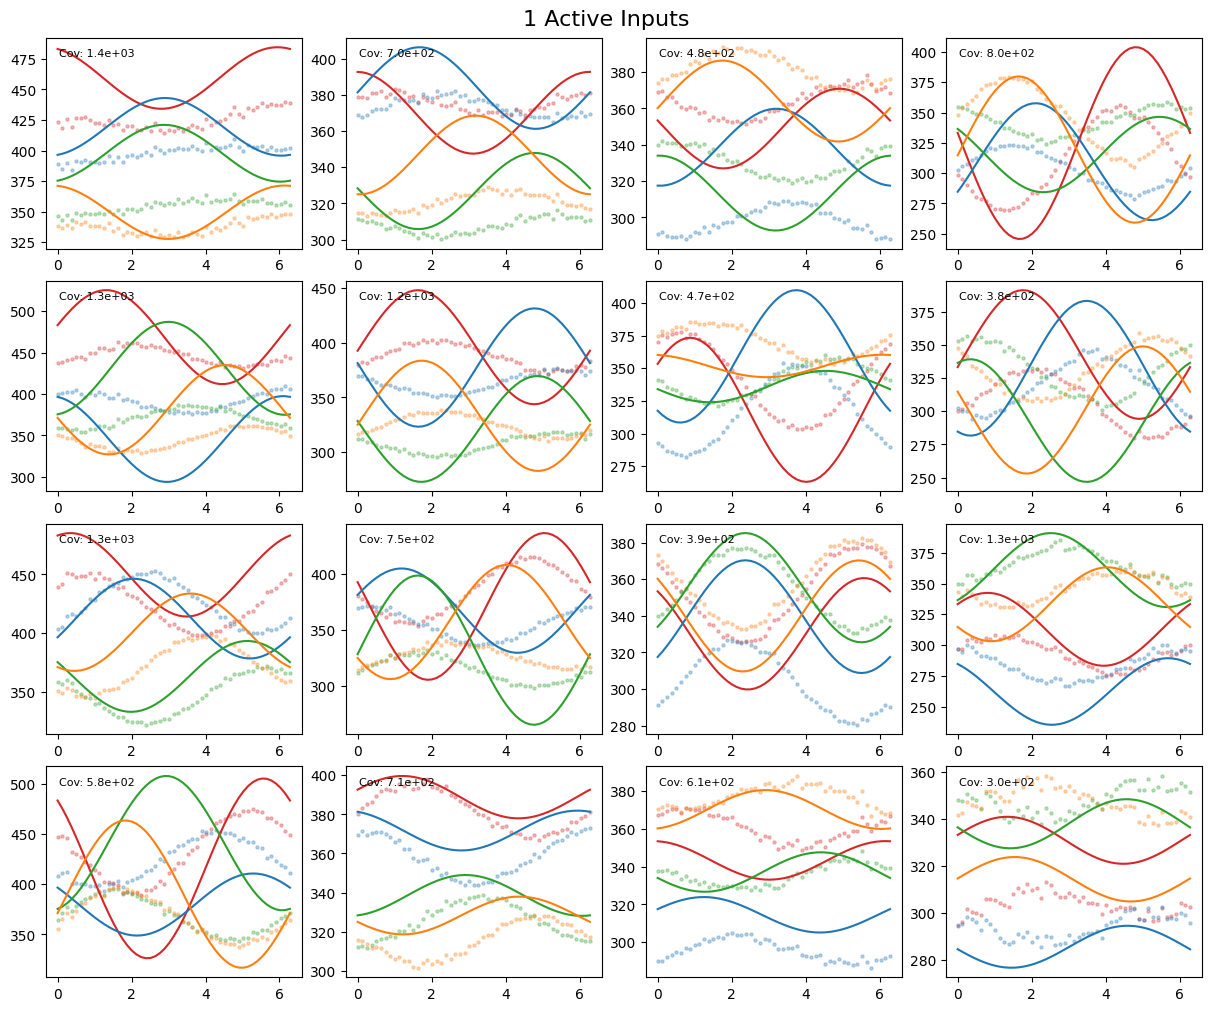

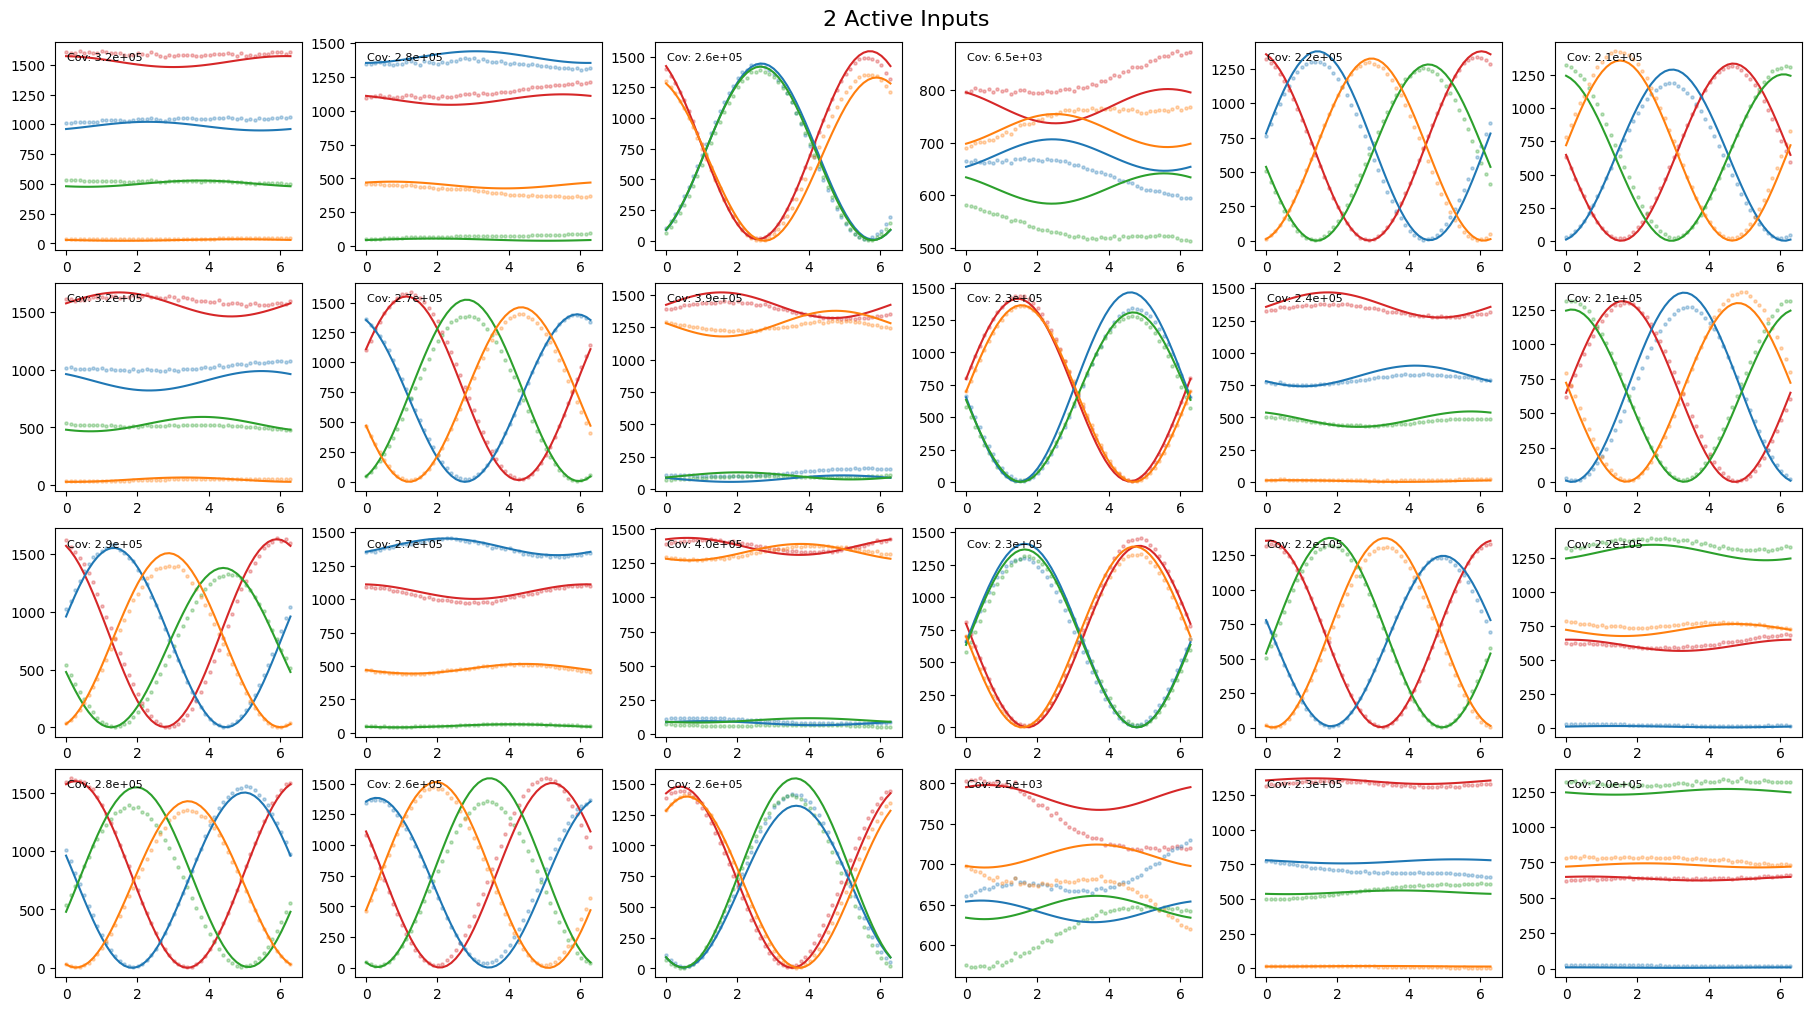

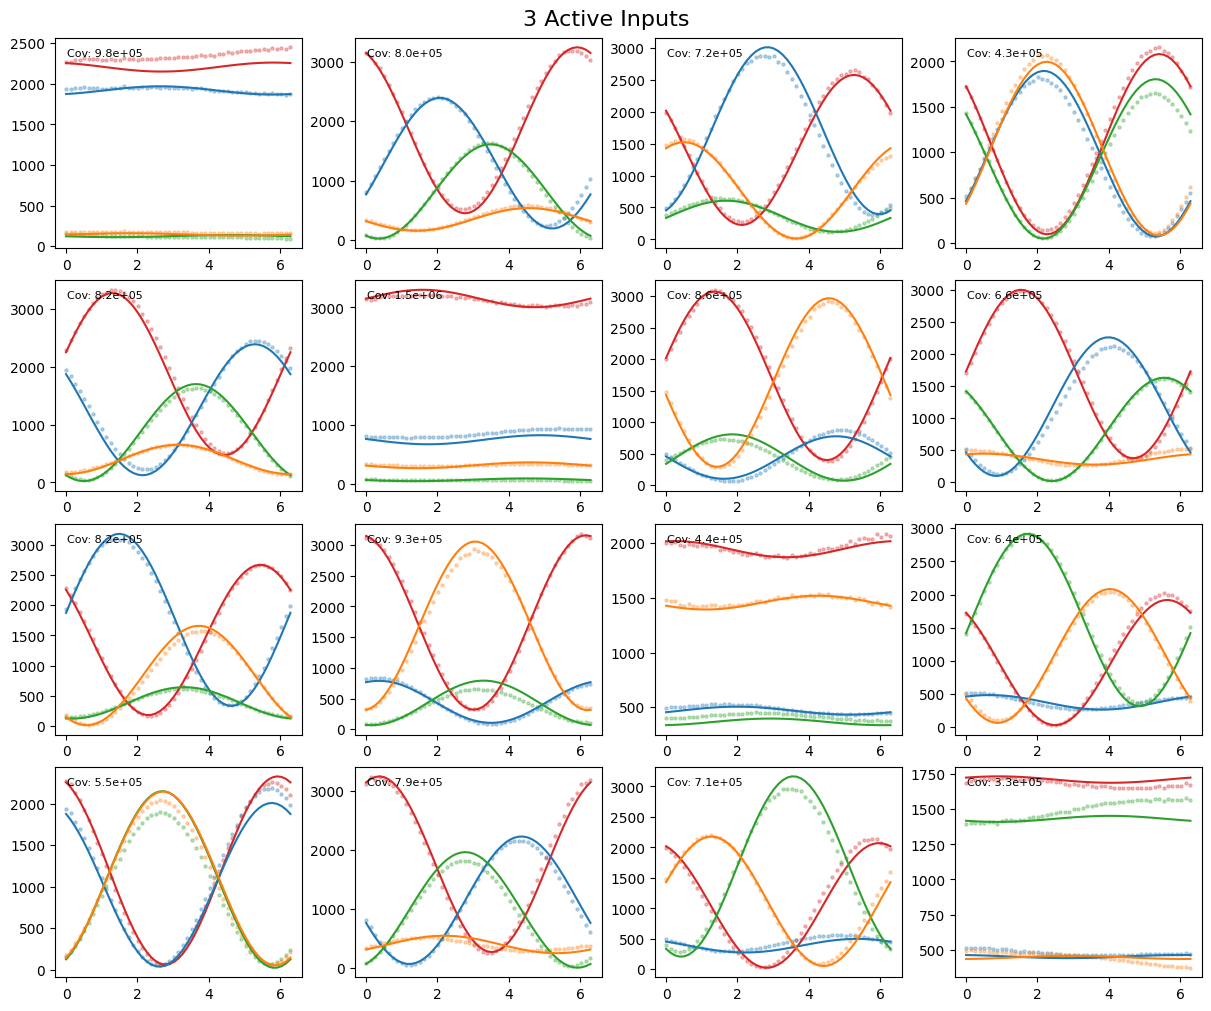

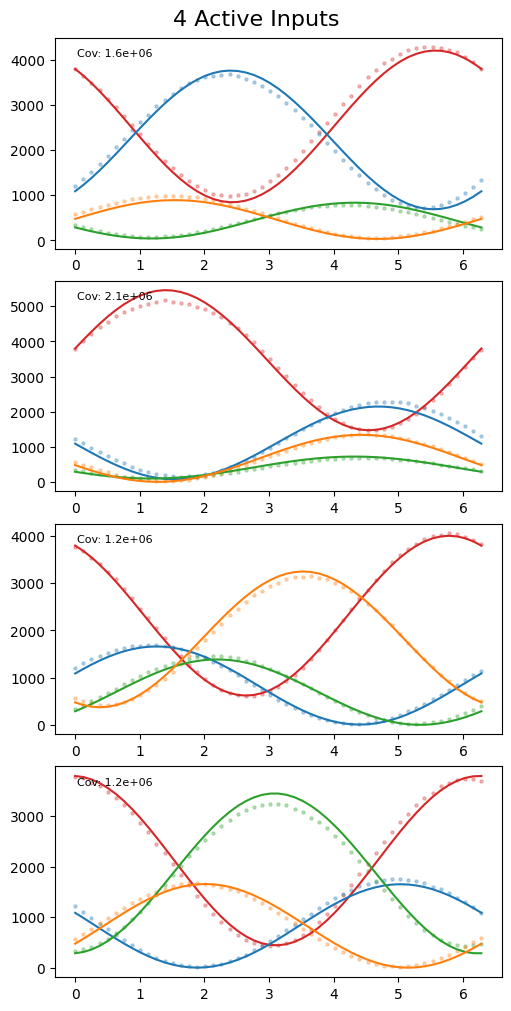

Total Covariance: 4.9615e+05


In [5]:
def predict_intensities(M, C, I_ON, I_OFF, I_stray, active_mask, scanned_idx, phases):
    N = len(phases)
    mask_arr = np.array(active_mask, dtype=bool)
    I_base = np.where(mask_arr, I_ON, I_OFF)
    # 4D Model: Ignore I_stray, construct 4-component vector
    I_batch = np.tile(I_base, (N, 1))
    phase_rotations = np.exp(-1j * phases)
    I_batch[:, scanned_idx] *= phase_rotations
    U = (C @ I_batch.T).T
    O = (M @ U.T).T
    return np.abs(O[:, :4])**2


def calculate_covariance(y_meas, y_pred):
    if len(y_meas) == 0: return 0.0
    return np.cov(y_meas.ravel(), y_pred.ravel())[0, 1]

def generate_plots_inline(results):
    if not results: return
    raw_data = np.load(DATA_PATH)
    M = results['M']; C = results['C']
    I_ON = results['I_ON']; I_OFF = results['I_OFF']; I_stray = results['I_stray']
    SHIFTER_MAP = {17: 3, 18: 2, 19: 1, 20: 0}
    
    # ... (Simplified data mapping logic from run_analysis.py) ...
    def get_mask_tuple(s):
        idx = [int(x)-1 for x in s.split('_')]
        m = [False]*4
        for i in idx: m[i] = True
        return tuple(m)

    data_map = {}
    keys = list(raw_data.keys())
    for key in keys:
        if not key.endswith('_fluxes'): continue
        match = re.search(r"inputs_([\d_]+)_shifter(\d+)_fluxes", key)
        if not match: continue
        scanned = SHIFTER_MAP.get(int(match.group(2)))
        if scanned is None: continue
        mask = get_mask_tuple(match.group(1))
        if mask not in data_map: data_map[mask] = {}
        data_map[mask][scanned] = key

    all_meas, all_pred = [], []
    COLORS = ['#d62728', '#1f77b4', '#2ca02c', '#ff7f0e']
    
    for num_active in range(1, 5):
        group_masks = sorted([m for m in data_map.keys() if sum(m) == num_active], key=lambda m: m, reverse=True)
        if not group_masks: continue
        
        fig, axs = plt.subplots(4, len(group_masks), figsize=(max(5, len(group_masks)*3), 10), constrained_layout=True)
        fig.suptitle(f"{num_active} Active Inputs", fontsize=16)
        axs = np.array(axs).reshape(4, -1)
        
        for c, mask in enumerate(group_masks):
            for r in range(4):
                shifter_idx = 3 - r
                ax = axs[r, c]
                if shifter_idx in data_map[mask]:
                    meas = raw_data[data_map[mask][shifter_idx]]
                    phases = np.linspace(0, 2*np.pi, len(meas))
                    model_pts = predict_intensities(M, C, I_ON, I_OFF, I_stray, mask, shifter_idx, phases)
                    all_meas.append(meas.ravel())
                    all_pred.append(model_pts.ravel())
                    for i in range(4):
                         ax.scatter(phases, meas[:, i], s=5, c=COLORS[i], alpha=0.3)
                         ax.plot(phases, model_pts[:, i], c=COLORS[i])
                    ax.text(0.05, 0.95, f"Cov: {calculate_covariance(meas, model_pts):.1e}", transform=ax.transAxes, fontsize=8, va='top')
        plt.show()

    if all_meas:
        print(f"Total Covariance: {calculate_covariance(np.concatenate(all_meas), np.concatenate(all_pred)):.4e}")

generate_plots_inline(results)

## 7. Conclusion

Le modèle 5D (incluant le stray light) offre une représentation robuste du système. La matrice $M$ est identifiée comme unitaire et équilibrée, tandis que la matrice $C$ et les états d'entrée capturent les imperfections d'injection.